In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import cv2
import os
import glob
import albumentations as abt
import math
from lxml import etree

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# **1. Dataset**

# **1.1. Load, resize, scale**
-chia đều cho /255.0 nên có thể thực hiện trước khi split

In [58]:
batch_size = 32
IMAGE_SIZE = 224  # VGG16
epochs = 300

In [59]:
img_dir_path = "/content/drive/MyDrive/dataset/images"
annotation_dir_path = "/content/drive/MyDrive/dataset/annotations"

In [60]:
os.path.join(img_dir_path,'*g')

'/content/drive/MyDrive/dataset/images/*g'

In [61]:
img_paths = glob.glob(os.path.join(img_dir_path,'*g')) # lấy đuôi kết thúc = g
img_paths[:3]

['/content/drive/MyDrive/dataset/images/Cars127.png',
 '/content/drive/MyDrive/dataset/images/Cars124.png',
 '/content/drive/MyDrive/dataset/images/Cars11.png']

In [62]:
img_paths.sort()  # sort() return None
img_paths[:3]

['/content/drive/MyDrive/dataset/images/Cars0.png',
 '/content/drive/MyDrive/dataset/images/Cars1.png',
 '/content/drive/MyDrive/dataset/images/Cars10.png']

In [63]:
cv2.imread(img_paths[4]).dtype

dtype('uint8')

In [64]:
def image_generator(img_paths):
    for path in img_paths:
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: Could not read image {path}")
            continue

        # bỏ alpha
        if img.shape[2] == 4:
            img = img[:, :, :3]

        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # resize image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # chuyển BGR (openCV) sang RGB
        img = (img / 255).astype("float32")  # chuyển uint8 (cho 0-255) sang float32 (cho 0.0-1.0) và scale
        yield img

imgs = image_generator(img_paths)

In [65]:
imgs = np.array(list(imgs))
# imgs = (imgs / 255).astype("float32")
imgs.shape  # 4D

(433, 224, 224, 3)

In [66]:
imgs[0]

array([[[0.21176471, 0.42352942, 0.5294118 ],
        [0.1764706 , 0.4862745 , 0.61960787],
        [0.30980393, 0.57254905, 0.7019608 ],
        ...,
        [0.16470589, 0.16862746, 0.16078432],
        [0.15686275, 0.16078432, 0.16862746],
        [0.13333334, 0.14117648, 0.14509805]],

       [[0.20784314, 0.4117647 , 0.5019608 ],
        [0.16078432, 0.47058824, 0.6039216 ],
        [0.20784314, 0.46666667, 0.58431375],
        ...,
        [0.1764706 , 0.18039216, 0.18039216],
        [0.16078432, 0.17254902, 0.16470589],
        [0.13333334, 0.14509805, 0.13725491]],

       [[0.24705882, 0.42352942, 0.49803922],
        [0.16862746, 0.4745098 , 0.6       ],
        [0.24705882, 0.49411765, 0.6       ],
        ...,
        [0.16078432, 0.16078432, 0.17254902],
        [0.1764706 , 0.19215687, 0.18431373],
        [0.13333334, 0.14901961, 0.14117648]],

       ...,

       [[0.2784314 , 0.1882353 , 0.15686275],
        [0.28235295, 0.19215687, 0.16078432],
        [0.28627452, 0

In [67]:
def resize_bbox(path):
    annotation = etree.parse(path)
    for size in annotation.xpath("size"):
        width = int(size.xpath("width")[0].text)  # int chuyển thành number
        height = int(size.xpath("height")[0].text)

    for bndbox in annotation.xpath("object/bndbox"):
        xmin = int(bndbox.xpath("xmin")[0].text)*(IMAGE_SIZE/width)  # int
        ymin = int(bndbox.xpath("ymin")[0].text)*(IMAGE_SIZE/height)
        xmax = int(bndbox.xpath("xmax")[0].text)*(IMAGE_SIZE/width)
        ymax = int(bndbox.xpath("ymax")[0].text)*(IMAGE_SIZE/height)

    return [round(xmin), round(ymin), round(xmax), round(ymax)]

# resize bounding-box để phù hợp kích thước mới (224x224) của ảnh
xml_paths = [annotation_dir_path + "/" + f for f in sorted(os.listdir(annotation_dir_path))]
bboxes = [resize_bbox(path) for path in xml_paths]

In [68]:
bboxes = np.array(bboxes)
bboxes.shape # 2D

(433, 4)

In [69]:
bboxes = (bboxes / IMAGE_SIZE).astype("float32")   # scale
bboxes[0]

array([0.45089287, 0.4642857 , 0.83928573, 0.6473214 ], dtype=float32)

In [70]:
bboxes[0]*224   # float

array([101., 104., 188., 145.], dtype=float32)

# **1.2. Load image**

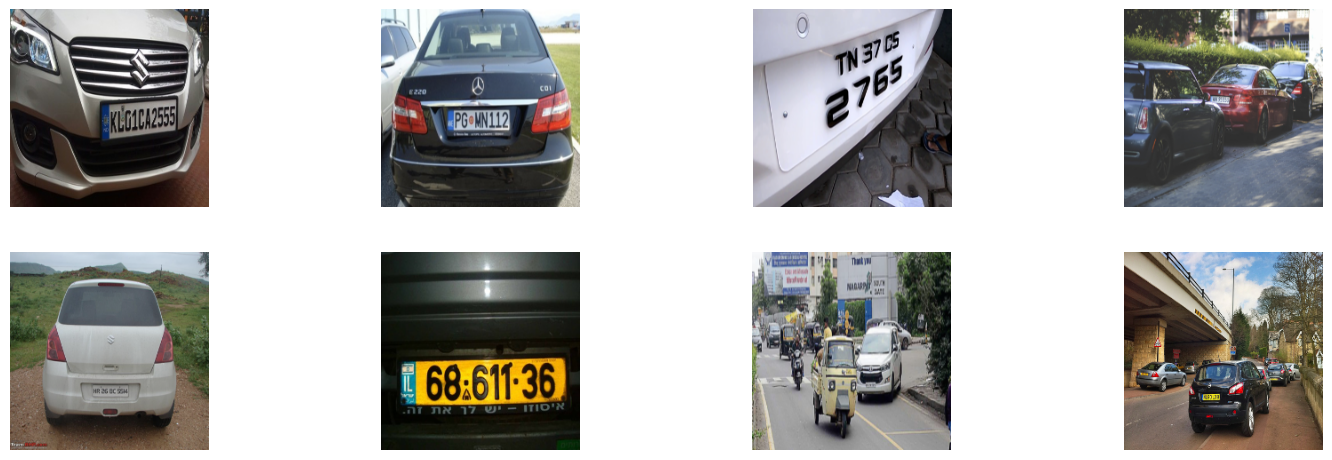

In [71]:
fig, axes = plt.subplots(2, 4, figsize=(15, 5))    # (fig, axes); axes: 2D (2, 4)
# fig.subplots_adjust(hspace=0.1)
fig.tight_layout()
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(imgs[i])
    ax.axis("off")

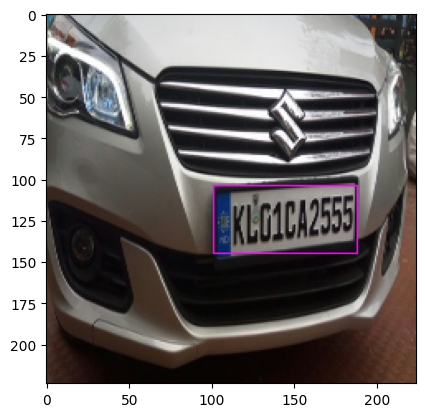

In [72]:
# image đã resize (224x224) và bbox mới
img0 = cv2.rectangle((imgs[0].copy()*255).astype('uint8'),
                    (int(bboxes[0][0]*IMAGE_SIZE), int(bboxes[0][1]*IMAGE_SIZE)),
                    (int(bboxes[0][2]*IMAGE_SIZE), int(bboxes[0][3]*IMAGE_SIZE)),
                    (255, 0, 255), 1)
plt.imshow(img0)
plt.show()

# **1.3. Split**

In [73]:
X_train, X_remain, y_train, y_remain = train_test_split(imgs, bboxes, test_size=0.2, random_state=123, shuffle=True)

In [74]:
length_val = round(0.15 * len(imgs))

X_val = X_remain[:length_val]
X_test = X_remain[length_val:]

y_val = y_remain[:length_val]
y_test = y_remain[length_val:]

In [75]:
X_train[9]

array([[[0.5686275 , 0.56078434, 0.4745098 ],
        [0.6156863 , 0.60784316, 0.52156866],
        [0.6509804 , 0.6431373 , 0.5647059 ],
        ...,
        [0.33333334, 0.5647059 , 0.76862746],
        [0.29411766, 0.5254902 , 0.74509805],
        [0.2784314 , 0.5176471 , 0.7490196 ]],

       [[0.7411765 , 0.7294118 , 0.654902  ],
        [0.7607843 , 0.7529412 , 0.6745098 ],
        [0.75686276, 0.7490196 , 0.6784314 ],
        ...,
        [0.25490198, 0.4745098 , 0.6745098 ],
        [0.22745098, 0.4509804 , 0.67058825],
        [0.21960784, 0.44313726, 0.6745098 ]],

       [[0.7294118 , 0.7176471 , 0.654902  ],
        [0.73333335, 0.72156864, 0.65882355],
        [0.7254902 , 0.7137255 , 0.654902  ],
        ...,
        [0.3019608 , 0.5019608 , 0.6862745 ],
        [0.2901961 , 0.49411765, 0.7019608 ],
        [0.27058825, 0.47058824, 0.6901961 ]],

       ...,

       [[0.7490196 , 0.7137255 , 0.6313726 ],
        [0.75686276, 0.72156864, 0.63529414],
        [0.76862746, 0

In [76]:
y_train[9]

array([0.3794643 , 0.5401786 , 0.62946427, 0.91964287], dtype=float32)

# **1.4. Tăng cường dữ liệu**
-chỉ đc tăng cường cho tập train

In [77]:
# Define augmentation pipeline
transform = abt.Compose([
    abt.HorizontalFlip(p=0.5),
    abt.RandomBrightnessContrast(p=0.2),
    abt.Rotate(limit=10, p=0.3),
    abt.Blur(blur_limit=3, p=0.1),
    abt.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=15, p=0.3),
], bbox_params=abt.BboxParams(format='pascal_voc', label_fields=['class_labels']))

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [78]:
def data_generator(images, bboxes, batch_size, augment=False):
    while True:  # model.fit() yêu cầu generator phải lặp vô hạn
        for i in range(0, len(images), batch_size):  # duyệt từng batch
            imgs_batch = images[i:i+batch_size]
            bboxes_batch = bboxes[i:i+batch_size]

            X_batch = []
            y_batch = []

            for img, bbox in zip(imgs_batch, bboxes_batch):
                bbox = [int(coord * IMAGE_SIZE) for coord in bbox]    # list hoặc tuple

                class_labels = ['plate']  # Albumentations yêu cầu có label đi kèm bbox

                if augment:
                  transformed = transform(image=img, bboxes=[bbox], class_labels=class_labels)

                  # Check if the bounding box still exists after augmentation
                  if transformed['bboxes']:  # Check if 'bboxes' is not empty (vd tọa độ bbox vượt quá tọa độ img)
                    img = transformed['image']
                    bbox = transformed['bboxes'][0]
                  else:
                    continue

                bbox = (np.array(bbox) / IMAGE_SIZE).astype("float32")

                X_batch.append(img)  # 4D
                y_batch.append(bbox)   # 2D

            yield (np.array(X_batch), np.array(y_batch))

In [79]:
train_gen = data_generator(X_train, y_train, batch_size=batch_size, augment=True)
val_gen = data_generator(X_val, y_val, batch_size=batch_size, augment=False)
test_gen = data_generator(X_test, y_test, batch_size=batch_size, augment=False)

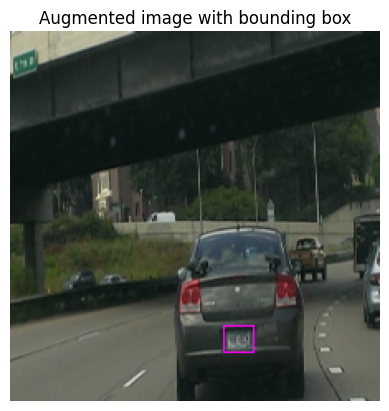

In [80]:
# check augmentation

X_aug, y_aug = next(test_gen)
img0 = cv2.rectangle((X_aug[0].copy()*255).astype("uint8"),
                      (int(y_aug[0][0]*IMAGE_SIZE), int(y_aug[0][1]*IMAGE_SIZE)),
                      (int(y_aug[0][2]*IMAGE_SIZE), int(y_aug[0][3]*IMAGE_SIZE)),
                      (255, 0, 255), 1)

plt.imshow(img0)
plt.title("Augmented image with bounding box")
plt.axis('off')
plt.show()

# **2. Model**

In [81]:
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# include_top=False: bỏ output-layer (Dense 1000 phân loại); dùng trọng số từ ImageNet
VGG16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

# ko cập nhật trọng số
for layer in VGG16.layers:
    layer.trainable = False

x = VGG16.output   # VGG16 output-layer

x = Flatten()(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.1)(x)

x = Dense(256, activation='relu')(x)

x = Dense(128, activation='relu')(x)

outputs = Dense(4, activation='linear')(x)  # cho hồi quy thay vì phân loại

model = Model(inputs=inputs, outputs=outputs)

In [82]:
model.compile(optimizer=Adam(), loss='mse', metrics=["mae"])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=math.ceil(len(X_train) / batch_size),  # dùng step nếu sd generator
    validation_steps=math.ceil(len(X_val) / batch_size),
    verbose=1,
    epochs=300,
    callbacks=[early_stopping]
)

Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 584ms/step - loss: 8.7875 - mae: 1.5794 - val_loss: 0.1938 - val_mae: 0.3668
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 416ms/step - loss: 0.7367 - mae: 0.6703 - val_loss: 0.1926 - val_mae: 0.3430
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - loss: 0.4124 - mae: 0.5141 - val_loss: 0.1435 - val_mae: 0.3064
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 473ms/step - loss: 0.2161 - mae: 0.3693 - val_loss: 0.0486 - val_mae: 0.1781
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - loss: 0.1272 - mae: 0.2851 - val_loss: 0.0321 - val_mae: 0.1429
Epoch 6/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - loss: 0.0994 - mae: 0.2485 - val_loss: 0.0290 - val_mae: 0.1348
Epoch 7/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - loss: 0.0749 - mae: 0.2165 - val_loss: 0.0306 - val_mae: 0.1393
Epoch 8/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step - loss: 0.0655 - mae: 0.2010 - val_loss: 0.0224 - val_mae: 0.1139
Epoch 9/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms

# **3. Đánh giá**

In [83]:
# dự đoán các giá trị liên tục => dùng mae thay vì acc
loss, mae = model.evaluate(val_gen, steps = math.ceil(len(X_val) / batch_size))
print(f'Val Loss: {loss:.4f}')
print(f'Val MAE: {mae}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0118 - mae: 0.0804 
Val Loss: 0.0126
Val MAE: 0.08045689016580582


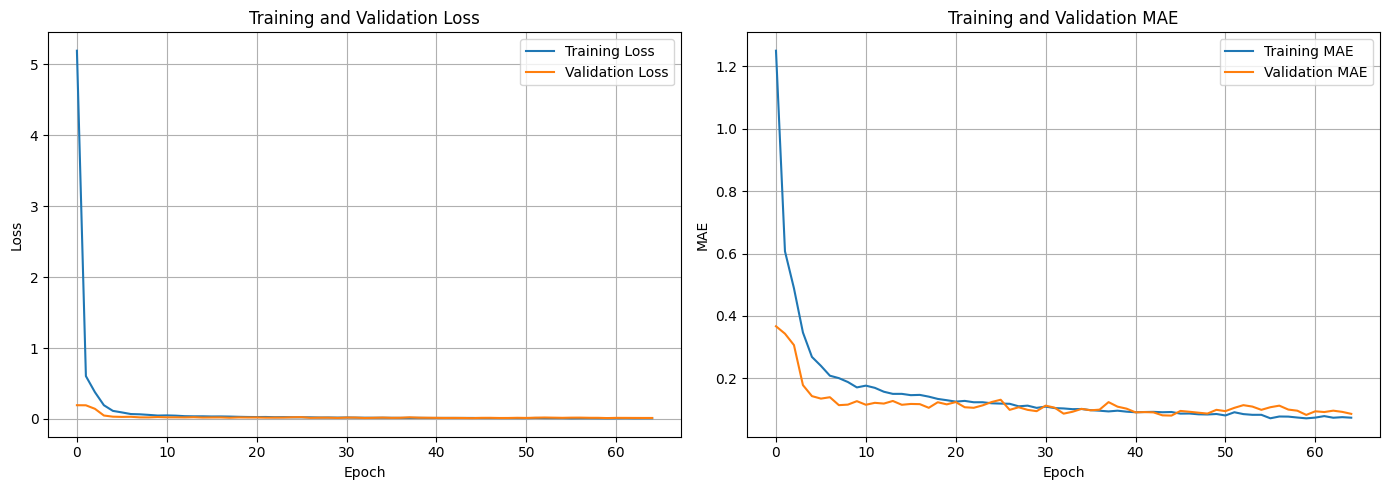

In [84]:
# Trích xuất lịch sử huấn luyện
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs_range = range(len(loss))

# Thiết lập đồ thị
plt.figure(figsize=(14, 5))

# ----- Đồ thị Loss -----
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ----- Đồ thị Accuracy -----
plt.subplot(1, 2, 2)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **4. Dự đoán**

In [85]:
def predict_and_display(X_predict, idx):
    y_predict = model.predict(X_predict)

    bbox_predict = [int(coord * IMAGE_SIZE) for coord in y_predict[0]]
    bbox_actual = [int(coord * IMAGE_SIZE) for coord in y_test[idx]]


    print(f"Predicted bbox: {bbox_predict}")
    print(f"Actual bbox: {bbox_actual}")

    image_copy = cv2.rectangle((X_predict[0].copy()*255).astype("uint8"),
                      (bbox_predict[0], bbox_predict[1]),
                      (bbox_predict[2], bbox_predict[3]),
                      (0, 255, 0), 1)

    plt.figure(figsize=(6,6))
    plt.imshow(image_copy)
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
Predicted bbox: [99, 98, 137, 128]
Actual bbox: [103, 104, 148, 153]


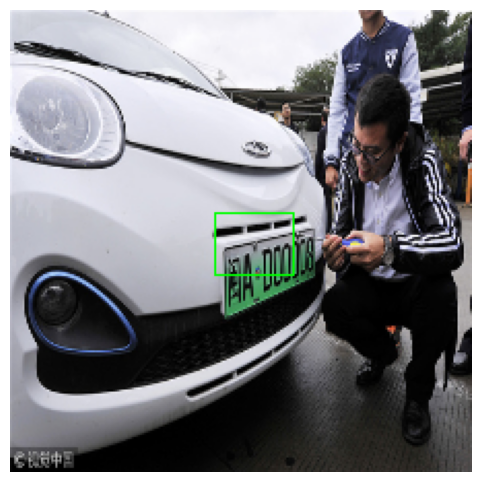

In [86]:
img11 = X_test[11]
predict_and_display(np.array([img11]), idx=11)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted bbox: [81, 95, 133, 121]
Actual bbox: [87, 82, 136, 119]


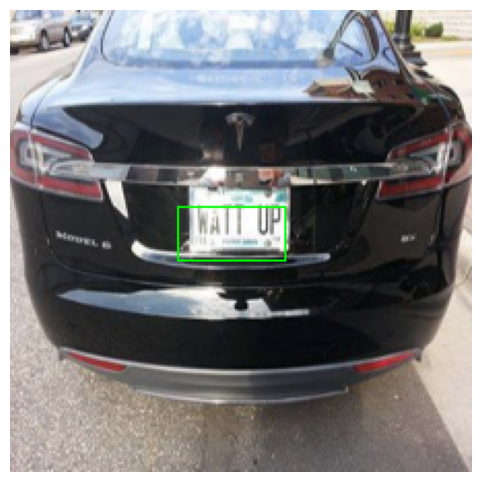

In [87]:
img2 = X_test[2]
predict_and_display(np.array([img2]), idx=2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted bbox: [61, 50, 153, 113]
Actual bbox: [58, 74, 164, 150]


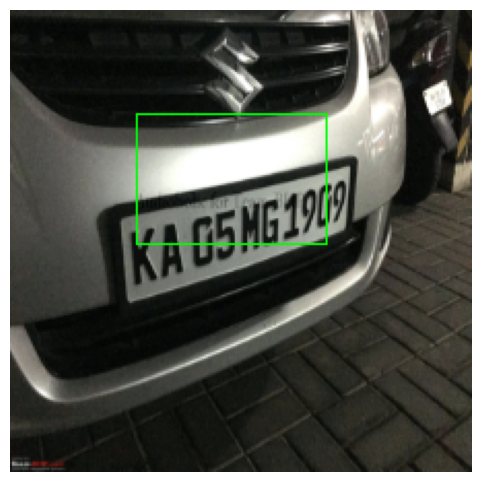

In [88]:
img19 = X_test[19]
predict_and_display(np.array([img19]), idx=19)

# **5. Save model**

In [89]:
model.save("/content/drive/MyDrive/model/model.keras")

print("Model saved successfully!")

Model saved successfully!
